In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

## 1. Load Data

In [13]:
# Regenerate features to ensure consistency with latest code
import src.features
import importlib
importlib.reload(src.features)
from src.features import extract_user_attributes, aggregate_user_features, generate_training_data

print("Regenerating Training Features from Raw Data (Snapshot Approach)...")
# Load Raw Train Data
train_raw_path = '../data/train.parquet'
train_df_raw = pd.read_parquet(train_raw_path)

# Apply Feature Engineering
train_df_raw = extract_user_attributes(train_df_raw)

# Use the new Snapshot Generation
# We will now get samples with "safe gaps" to reduce false positives
df = generate_training_data(train_df_raw)

print(f"Dataset Shape: {df.shape}")
print(f"Churn Rate: {df['target'].mean():.2%}")

# Check the distribution of 'days_since_last_session' for Target 0
print("\nAvg Gap for Non-Churners (Target 0):")
print(df[df['target']==0]['days_since_last_session'].describe())

df.head()

Regenerating Training Features from Raw Data (Snapshot Approach)...
Generated 85807 snapshots.
Class Balance: 12.28%
Generated 85807 snapshots.
Class Balance: 12.28%
Dataset Shape: (85807, 50)
Churn Rate: 12.28%

Avg Gap for Non-Churners (Target 0):
count    75268.000000
mean        15.085518
std         13.654632
min          0.000000
25%          2.849997
50%         11.000000
75%         26.000000
max         45.878287
Name: days_since_last_session, dtype: float64
Dataset Shape: (85807, 50)
Churn Rate: 12.28%

Avg Gap for Non-Churners (Target 0):
count    75268.000000
mean        15.085518
std         13.654632
min          0.000000
25%          2.849997
50%         11.000000
75%         26.000000
max         45.878287
Name: days_since_last_session, dtype: float64


,userId,cutoff_ts,gender,level,platform,is_thumbs_up,is_thumbs_down,is_ad,is_error,is_song,length,downgrade,songs_last_1d,errors_last_1d,listen_time_last_1d,unique_artists_last_1d,unique_songs_last_1d,songs_last_3d,errors_last_3d,listen_time_last_3d,unique_artists_last_3d,unique_songs_last_3d,songs_last_7d,errors_last_7d,listen_time_last_7d,unique_artists_last_7d,unique_songs_last_7d,songs_last_14d,errors_last_14d,listen_time_last_14d,unique_artists_last_14d,unique_songs_last_14d,songs_last_30d,errors_last_30d,listen_time_last_30d,unique_artists_last_30d,unique_songs_last_30d,account_lifetime,avg_songs_per_day,thumbs_ratio,errors_per_song,trend_songs_7d_vs_30d,trend_listen_time_7d_vs_30d,total_sessions,avg_days_between_sessions,days_since_last_session,avg_songs_per_session,avg_session_duration,state_freq,target
0,1000025,2018-10-11 20:33:05,M,paid,Windows,69,10,4,0,975,243551.84526,0,69.0,0.0,18710.06828,68.0,69.0,237.0,0.0,60354.32190,218.0,231.0,362.0,0.0,91829.20396,326.0,345.0,975.0,0.0,243551.84526,761.0,886.0,975.0,0.0,243551.84526,761.0,886.0,93.460382,10.321788,0.862500,0.000000,1.484519,1.508164,11,8.496398,0.001887,88.636364,22141.076842,0.012790,1
1,1000025,2018-10-15 20:33:05,M,paid,Windows,73,10,4,0,1127,284335.05795,0,97.0,0.0,27044.03111,90.0,95.0,97.0,0.0,27044.03111,90.0,95.0,389.0,0.0,101137.53459,341.0,374.0,1127.0,0.0,284335.05795,858.0,1020.0,1127.0,0.0,284335.05795,858.0,1020.0,97.460382,11.446228,0.869048,0.000000,1.380167,1.422792,13,7.496952,0.002118,86.692308,21871.927535,0.012790,1
2,1000025,2018-10-17 20:33:05,M,paid,Windows,86,11,4,1,1450,364648.14579,0,249.0,1.0,61665.34996,220.0,241.0,420.0,1.0,107357.11895,355.0,402.0,544.0,1.0,139806.36881,449.0,517.0,1054.0,1.0,265584.18816,808.0,962.0,1450.0,1.0,364648.14579,1039.0,1295.0,99.460382,14.433551,0.877551,0.000689,1.500276,1.533601,16,6.216274,0.000336,90.625000,22790.509112,0.012790,1
3,1000035,2018-10-31 10:54:56,F,paid,Linux,57,9,5,0,692,169813.23719,0,0.0,0.0,0.00000,0.0,0.0,108.0,0.0,26370.58943,104.0,105.0,221.0,0.0,53039.80842,204.0,215.0,559.0,0.0,137860.47464,464.0,531.0,692.0,0.0,169813.23719,563.0,653.0,48.643449,13.939402,0.850746,0.000000,1.276719,1.249365,14,3.474532,2.698958,49.428571,12129.516942,0.011046,0
4,1000035,2018-11-06 19:28:13,F,paid,Linux,61,9,5,0,745,182963.33234,0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,53.0,0.0,13150.09515,52.0,53.0,274.0,0.0,66189.90357,250.0,267.0,742.0,0.0,182337.70105,596.0,700.0,54.999896,13.303596,0.859155,0.000000,0.285560,0.288477,15,3.666660,3.840139,49.666667,12197.555489,0.011046,0


## 2. Preprocessing & Splitting

We will use a **Stratified Split** to maintain the churn ratio in both training and test sets.
We will also define a `ColumnTransformer` to handle:
- **Numerical Features**: Standard Scaling.
- **Categorical Features**: One-Hot Encoding.

In [14]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 1. Separate Features and Target
# Drop target and metadata columns
cols_to_drop = ["target", "userId", "cutoff_ts"]
X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
y = df['target']

# 2. Identify Column Types
# Categorical: 'gender', 'level', 'platform' (low cardinality)
# Note: 'state_freq' is numerical, so it goes to num_cols
categorical_cols = ['gender', 'level', 'platform']
numerical_cols = [c for c in X.columns if c not in categorical_cols]

print(f"Categorical Columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical Columns ({len(numerical_cols)}): {numerical_cols[:5]} ...")

# 3. Group-Based Train-Test Split
# We split by USER to ensure no user appears in both train and test (prevent leakage)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=RANDOM_SEED)
train_idx, test_idx = next(splitter.split(X, y, groups=df['userId']))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

print(f"\nTraining Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")
print(f"Train Churn Rate: {y_train.mean():.2%}")
print(f"Test Churn Rate: {y_test.mean():.2%}")

Categorical Columns (3): ['gender', 'level', 'platform']
Numerical Columns (44): ['is_thumbs_up', 'is_thumbs_down', 'is_ad', 'is_error', 'is_song'] ...

Training Shape: (68601, 47)
Test Shape: (17206, 47)
Train Churn Rate: 12.42%
Test Churn Rate: 11.75%


In [15]:
# 4. Define Preprocessing Pipeline
# We use a Pipeline to prevent data leakage (scaling parameters learned only on train)

# Numerical Transformer: Impute missing values with median, then scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Impute missing values with 'missing', then OneHotEncode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ]
)

# Verify the pipeline works on training data
X_train_processed = preprocessor.fit_transform(X_train)
print(f"Processed Feature Matrix Shape: {X_train_processed.shape}")

Processed Feature Matrix Shape: (68601, 51)


## 3. Baseline Model Evaluation

We will evaluate the following industry-standard models:
1.  **Logistic Regression**: Simple baseline for interpretability.
2.  **Random Forest**: Robust bagging ensemble.
3.  **XGBoost**: Gradient boosting (often SOTA for tabular data).
4.  **LightGBM**: Faster and often more accurate gradient boosting.
5.  **CatBoost**: Excellent for categorical features (though we OHE them here).

**Metrics**:
- **F1-Score**: Harmonic mean of precision and recall (crucial for imbalanced churn).
- **ROC-AUC**: Ability to distinguish between classes.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    # Removed use_label_encoder=False as it's deprecated and causing warnings
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED),
    "LightGBM": LGBMClassifier(random_state=RANDOM_SEED, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=RANDOM_SEED)
}

# Evaluation Function
def evaluate_models(models, X, y, preprocessor):
    results = []
    for name, model in models.items():
        # Create full pipeline
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        
        # Cross-Validation (5-fold)
        # Added 'accuracy' to scoring
        cv_results = cross_validate(clf, X, y, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])
        
        results.append({
            "Model": name,
            "F1 Score (Mean)": cv_results['test_f1'].mean(),
            "F1 Score (Std)": cv_results['test_f1'].std(),
            "ROC-AUC (Mean)": cv_results['test_roc_auc'].mean(),
            "ROC-AUC (Std)": cv_results['test_roc_auc'].std(),
            "Accuracy (Mean)": cv_results['test_accuracy'].mean(),
            "Accuracy (Std)": cv_results['test_accuracy'].std(),
            "CV F1 Scores": np.round(cv_results['test_f1'], 3) # Show individual scores
        })
        print(f"Evaluated {name}...")
        
    return pd.DataFrame(results).sort_values(by="F1 Score (Mean)", ascending=False)

# Run Evaluation
# We convert X_train to numpy array to avoid LightGBM feature name warnings
# The pipeline handles the transformation, but passing a dataframe to fit/predict
# inside the pipeline can sometimes trigger this warning in newer sklearn/lgbm versions
# when the column transformer returns a numpy array (which it does).
results_df = evaluate_models(models, X_train, y_train, preprocessor)
results_df

Evaluated Logistic Regression...
Evaluated Random Forest...
Evaluated Random Forest...
Evaluated XGBoost...
Evaluated XGBoost...
Evaluated LightGBM...
Evaluated LightGBM...
Evaluated CatBoost...
Evaluated CatBoost...


,Model,F1 Score (Mean),F1 Score (Std),ROC-AUC (Mean),ROC-AUC (Std),Accuracy (Mean),Accuracy (Std),CV F1 Scores
2,XGBoost,0.364993,0.018530,0.869476,0.003011,0.885031,0.002041,"[0.362, 0.395, 0.361, 0.369, 0.338]"
4,CatBoost,0.354267,0.017738,0.881818,0.004671,0.887144,0.001656,"[0.356, 0.386, 0.341, 0.353, 0.335]"
3,LightGBM,0.347378,0.014307,0.881862,0.004966,0.887917,0.001273,"[0.352, 0.369, 0.334, 0.352, 0.33]"
0,Logistic Regression,0.287414,0.017777,0.852139,0.003456,0.883369,0.001835,"[0.304, 0.293, 0.307, 0.267, 0.265]"
1,Random Forest,0.287321,0.010085,0.857254,0.004943,0.883967,0.001346,"[0.282, 0.302, 0.294, 0.287, 0.273]"


## 4. Hyperparameter Tuning

We will now optimize the hyperparameters for our top two performing models: **XGBoost** and **CatBoost**.
We use `RandomizedSearchCV` which is more efficient than Grid Search as it samples a fixed number of parameter settings from specified distributions.


In [17]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

# Define parameter grids
xgb_params = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5, 6, 8],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2, 0.5]
}

# Helper function for tuning
def tune_model(model, params, X, y, preprocessor, n_iter=20):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    search = RandomizedSearchCV(
        pipeline, 
        param_distributions=params, 
        n_iter=n_iter, 
        scoring='f1', 
        cv=3, 
        verbose=1, 
        random_state=RANDOM_SEED, 
        n_jobs=-1
    )
    
    search.fit(X, y)
    return search

# Tune XGBoost
print("--- Tuning XGBoost ---")
# Set n_jobs=1 to avoid oversubscription
xgb_model = XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED, n_jobs=1)
xgb_search = tune_model(xgb_model, xgb_params, X_train, y_train, preprocessor)

print(f"Best XGBoost F1: {xgb_search.best_score_:.4f}")
print(f"Best XGBoost Params: {xgb_search.best_params_}")

--- Tuning XGBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits


Best XGBoost F1: 0.3577
Best XGBoost Params: {'classifier__subsample': 0.7, 'classifier__n_estimators': 300, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.7}


--- Tuning XGBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost F1: 0.6910
Best XGBoost Params: {'classifier__subsample': 0.7, 'classifier__n_estimators': 300, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 1.0}


In [18]:
# Tune LightGBM
print("\n--- Tuning LightGBM ---")

# Define a lighter grid for faster convergence
lgbm_params_fast = {
    'classifier__n_estimators': [100, 200, 300],       # Removed 500 to speed up
    'classifier__learning_rate': [0.05, 0.1, 0.2],     # Removed 0.01 (too slow)
    'classifier__num_leaves': [20, 31, 50],            # Reduced complexity
    'classifier__max_depth': [-1, 5, 10],              # Reduced depth options
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Set n_jobs=1 to avoid CPU oversubscription/deadlocks which cause the 20m+ wait
lgbm_model = LGBMClassifier(random_state=RANDOM_SEED, verbose=-1, n_jobs=1)

# Reduce n_iter to 15 for faster results
# We suppress the specific warning about feature names here as well
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    lgbm_search = tune_model(lgbm_model, lgbm_params_fast, X_train, y_train, preprocessor, n_iter=15)

print(f"Best LightGBM F1: {lgbm_search.best_score_:.4f}")
print(f"Best LightGBM Params: {lgbm_search.best_params_}")


--- Tuning LightGBM ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best LightGBM F1: 0.3602
Best LightGBM Params: {'classifier__subsample': 0.9, 'classifier__num_leaves': 50, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.8}


Best LightGBM F1: 0.6947
Best LightGBM Params: {'classifier__subsample': 1.0, 'classifier__num_leaves': 20, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 1.0}

## 5. Ensemble Modeling (Stacking)

We will now combine our tuned **XGBoost** and **CatBoost** models using a `StackingClassifier`.
This technique uses a meta-model (Logistic Regression) to learn the best combination of the base models' predictions.
We use the optimal hyperparameters found in the previous step.

In [19]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier

# 1. Retrieve Best Models from Searches
best_xgb = xgb_search.best_estimator_.named_steps["classifier"]  # type: ignore
best_lgbm = lgbm_search.best_estimator_.named_steps["classifier"]  # type: ignore

# For CatBoost, we use the default model directly (skipping tuning as defaults are strong)
# We set thread_count=1 to avoid CPU oversubscription
best_cat = CatBoostClassifier(verbose=0, random_state=RANDOM_SEED, thread_count=1)

# 2. Create Stacking Ensemble
# We wrap each base model in the preprocessor pipeline so they can handle the raw data
estimators = [
    ('xgb', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_xgb)])),
    ('cat', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_cat)])),
    ('lgbm', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_lgbm)]))
]

# The final estimator uses the predictions of the base estimators
# We use Logistic Regression as the meta-learner
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=RANDOM_SEED),
    cv=5,
    n_jobs=-1
)

# 3. Evaluate Stacking Model
print("Evaluating Stacking Classifier (this may take a moment)...")
cv_results_stack = cross_validate(stacking_clf, X_train, y_train, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])

print(f"Stacking F1 Score: {cv_results_stack['test_f1'].mean():.4f} (+/- {cv_results_stack['test_f1'].std():.4f})")
print(f"Stacking ROC-AUC: {cv_results_stack['test_roc_auc'].mean():.4f}")
print(f"Stacking Accuracy: {cv_results_stack['test_accuracy'].mean():.4f}")

Evaluating Stacking Classifier (this may take a moment)...


/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Stacking F1 Score: 0.3769 (+/- 0.0167)
Stacking ROC-AUC: 0.8830
Stacking Accuracy: 0.8869


## 6. Threshold Optimization

Standard models use a default threshold of 0.5 to classify a user as "Churn" or "Not Churn".
However, since our dataset is imbalanced and we care deeply about F1-Score, this default is rarely optimal.

We will:
1.  Generate probability predictions using Cross-Validation (to avoid overfitting).
2.  Iterate through all possible thresholds (0.01 to 0.99).
3.  Find the threshold that maximizes the F1-Score.

Generating cross-validated predictions...


/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Optimal Threshold: 0.15
Max Cross-Validated F1 Score: 0.5183


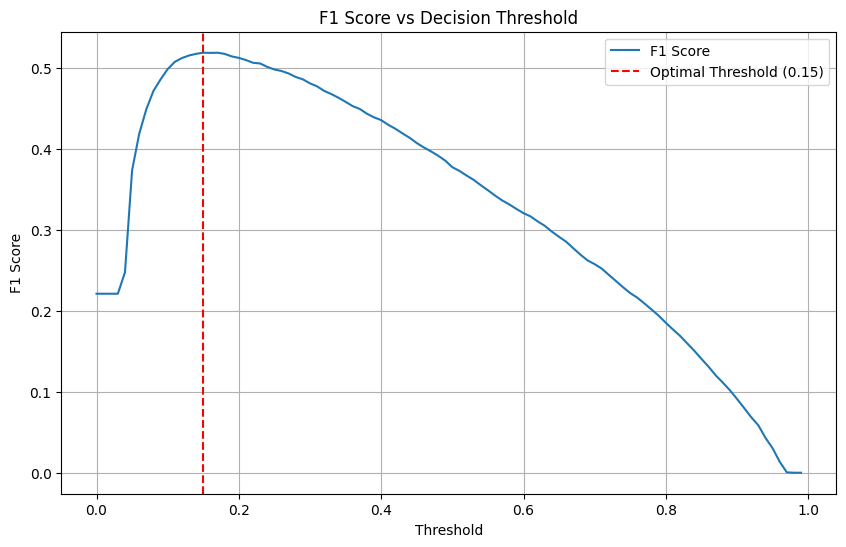

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

# 1. Get probability predictions via Cross-Validation
# This ensures we don't overfit the threshold to the training data
print("Generating cross-validated predictions...")
y_scores = cross_val_predict(stacking_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# 2. Find Optimal Threshold
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    f1_scores.append(f1_score(y_train, y_pred_thresh))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1_score = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Max Cross-Validated F1 Score: {max_f1_score:.4f}")

# Plot F1 vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.title('F1 Score vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

## 7. Final Evaluation on Test Set

Now we perform the final "exam". We will:
1.  Retrain the Stacking Model on the **full training set**.
2.  Predict probabilities on the **held-out test set**.
3.  Apply our **Optimal Threshold** to generate final class predictions.
4.  Report the final performance metrics.

Retraining Stacking Model on full training set...


/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Final Test Set Performance ---
ROC-AUC: 0.8913

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     15184
           1       0.42      0.69      0.52      2022

    accuracy                           0.85     17206
   macro avg       0.69      0.78      0.72     17206
weighted avg       0.89      0.85      0.87     17206



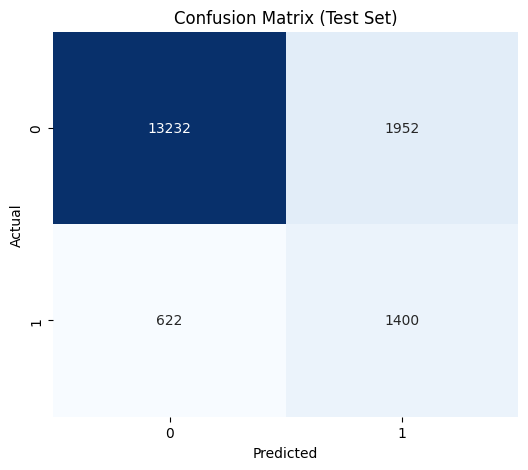

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Retrain on Full Training Set
print("Retraining Stacking Model on full training set...")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    stacking_clf.fit(X_train, y_train)

# 2. Predict on Test Set
y_test_probs = stacking_clf.predict_proba(X_test)[:, 1]  # type: ignore
y_test_pred = (y_test_probs >= optimal_threshold).astype(int)

# 3. Final Metrics
print("\n--- Final Test Set Performance ---")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Generate Submission File

We will now generate predictions for the **Test Dataset** (`data/test.parquet`).
Since this is likely raw data, we need to apply the same **Feature Engineering** steps as we did for the training data.

**Steps**:
1.  Load `test.parquet`.
2.  Apply `extract_user_attributes` and `aggregate_user_features`.
3.  Generate probabilities using the trained `stacking_clf`.
4.  Apply the `optimal_threshold`.
5.  Save to `submission.csv`.

In [22]:
import importlib
import src.features
importlib.reload(src.features)
from src.features import extract_user_attributes, aggregate_user_features

# 1. Load Raw Test Data
test_data_path = '../data/test.parquet'
print(f"Loading test data from {test_data_path}...")
test_df_raw = pd.read_parquet(test_data_path)

# 2. Apply Feature Engineering
print("Applying feature engineering...")
test_df_raw = extract_user_attributes(test_df_raw)

# --- CRITICAL FIX FOR TEST SET ---
# The test set is a snapshot of the "current" state.
# We must calculate features relative to the END of the test period (Global Max Timestamp),
# NOT relative to each user's last event.
# If we use user's last event (default), 'days_since_last_session' would be 0 for everyone,
# destroying the most important churn signal (inactivity).

global_max_ts = test_df_raw['ts'].max()
print(f"Global Test Cutoff Timestamp: {global_max_ts}")

# Create a snapshot dataframe for test users
test_snapshot_df = pd.DataFrame({
    'userId': test_df_raw['userId'].unique(),
    'cutoff_ts': global_max_ts
})

# Generate features using this common cutoff
test_features = aggregate_user_features(test_df_raw, snapshot_df=test_snapshot_df)

# The result has a MultiIndex (userId, cutoff_ts), we drop the cutoff_ts level
test_features = test_features.reset_index(level='cutoff_ts', drop=True)

# Drop 'target' if it exists
if 'target' in test_features.columns:
    test_features = test_features.drop(columns=['target'])

# Ensure columns match training data
missing_cols = set(X_train.columns) - set(test_features.columns)
for c in missing_cols:
    test_features[c] = 0

# Reorder columns to match X_train
test_features = test_features[X_train.columns]

print(f"Test Features Shape: {test_features.shape}")
print(f"Avg Days Since Last Session: {test_features['days_since_last_session'].mean():.2f} days")

# 3. Generate Predictions
print("Generating predictions...")
test_probs = stacking_clf.predict_proba(test_features)[:, 1]  # type: ignore
test_preds = (test_probs >= optimal_threshold).astype(int)

# 4. Create Submission DataFrame
submission_df = pd.DataFrame({
    'id': test_features.index,
    'target': test_preds
})

# 5. Save to CSV
submission_path = '../data/submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")
print(submission_df.head())

Loading test data from ../data/test.parquet...
Applying feature engineering...
Applying feature engineering...
Global Test Cutoff Timestamp: 2018-11-20 00:00:00
Global Test Cutoff Timestamp: 2018-11-20 00:00:00
Test Features Shape: (2904, 47)
Avg Days Since Last Session: 5.14 days
Generating predictions...
Submission saved to ../data/submission.csv
        id  target
0  1000655       0
1  1000963       1
2  1001129       0
3  1001963       1
4  1002283       1
Test Features Shape: (2904, 47)
Avg Days Since Last Session: 5.14 days
Generating predictions...
Submission saved to ../data/submission.csv
        id  target
0  1000655       0
1  1000963       1
2  1001129       0
3  1001963       1
4  1002283       1


**Submit Command Line**: `kaggle competitions submit -c churn-prediction-25-26 -f Project/data/submission.csv -m "Raynor X Attempt"`

In [23]:
# --- SAVE MODEL ARTIFACTS ---
import joblib
import os

# Create models directory if it doesn't exist
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

print(f"Saving artifacts to {models_dir}...")

# 1. Save the Stacking Model
model_path = os.path.join(models_dir, "stacking_model.joblib")
joblib.dump(stacking_clf, model_path)
print(f"- Model saved to {model_path}")

# 2. Save the Preprocessor
preprocessor_path = os.path.join(models_dir, "preprocessor.joblib")
joblib.dump(preprocessor, preprocessor_path)
print(f"- Preprocessor saved to {preprocessor_path}")

# 3. Save the Optimal Threshold
threshold_path = os.path.join(models_dir, "optimal_threshold.joblib")
joblib.dump(optimal_threshold, threshold_path)
print(f"- Optimal Threshold ({optimal_threshold:.4f}) saved to {threshold_path}")

# 4. Save Feature Names (Crucial for alignment)
features_path = os.path.join(models_dir, "feature_names.joblib")
joblib.dump(X_train.columns, features_path)
print(f"- Feature names saved to {features_path}")

Saving artifacts to ../models...
- Model saved to ../models/stacking_model.joblib
- Preprocessor saved to ../models/preprocessor.joblib
- Optimal Threshold (0.1500) saved to ../models/optimal_threshold.joblib
- Feature names saved to ../models/feature_names.joblib
